## 1. Hashing

-----------------------------------------------------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

With the hash_function define below we map strings to a 32 bits vector in order to obtain a uniform distribution across the number of requests. 

In [2]:
def hash_function(string):
    m=2**32
    hash_= 7
    for i in range(len(string)):
        x = encoding(string[i])
        hash_=((hash_*31))+x
    hash_=hash_%m 
    binary = bin(hash_)[2:]
    str_binary = str(binary)
    return str_binary

On each char of the input string, such as a line of the file,we apply the ecoding before computing the hashing.
With this function we convert each item of the string into an ASCII char.

In [3]:
def encoding(string):
    s=0
    for char in string:
        s+=ord(char) 
    return s

-----------------------------------------------------------------------------------------------------

## Hyperloglog
Now we use the Hyperloglog structure to store our binary codes. To remove the effects of outliers, and to lower the variance, HyperLogLog splits the input into several subsets called “buckets”. Then for each buckets the estimates are combined using an harmonic mean to deduce an estimate of the cardinality for the entire set. The implementation we provide is an Hyperloglog 13-bit since our m is $2^{13}$.


### Add item to the buckets: 
One of the supported operation on this data structure is to **add** items.
It consists of computing the hash each line in the file with the hash_function define above, getting the first n bits (where n is ${\log_{2}(m)}$) to obtain the address of the bucket to modify. With the remaining bits we compute ${\rho(w)}$ which returns the position of the leftmost 1, computed with the below function **max_zeros**.

The new value of the register will be the maximum between the current value of the register and ${\rho(w)}$.

In [4]:
def max_zeros(string):
    maximum = 0
    while string[maximum] == '0' :
        maximum+=1
        if len(string[maximum:]) == 0:
            break
    return maximum

Assuming that the output of our hash is for example hash(input)=101101110110111001100011010110100. We use the leftmost n=13 bits to find the bucket index, so **1011011101101**11001100011010110100 tells us which bucket to update. 

```
j = int(digit[:n],2)
``` 


From the remaining, 1011011101101**11001100011010110100** we extract the longest run of consecutive 0s from the rightmost bits and they are used to find the bucket number. 

``` 
w = digit[n:]  
```

In [5]:
def hyperloglog(file):
    #the input file has 139000000 lines
    length_file = 139000000    
    #open the file
    f = open(file, "r") 
    n=13
    m = 2**n
    #initialize the buckets
    buckets = [0 for x in range (m)]
    #for each rows in the file 'hash.txt'
    for row in range(0,length_file):
        #read one line at time
        line = f.readline(row).strip()
        
        #compute the hash function on it and save the value in digit
        digit = hash_function(line) 
        
        #filling with zeros in order to obtain digit of 32 bit
        if len(digit)<32: 
            digit = '0'*(32-len(digit))+digit
             
        #add items to the buckets
        j = int(digit[:n],2) 
        w=digit[n:] 
        #If the number of leftmost zeros for the i-th element is x and it is higher than the max x generated, 
        #then x is stored as the new max value for that bucket.
        buckets[j]=max(buckets[j],max_zeros(w))
    
    #print the buckets distribution
    plt.hist(buckets,color='c')
    plt.title('Distribution of the items in the buckets')
    
    #computing cardinality 
    cardinality = card(buckets,m)
    return (cardinality)

### Cardinality of the hyperloglog:

The cardinality of the hyperloglog is given by:
${\displaystyle E=\alpha _{m}m^{2}Z}$ 


Where Z is: 
${\displaystyle Z={\Bigg (}\sum _{j=1}^{m}{2^{-M[j]}}{\Bigg )}^{-1}}$ 


and $\alpha _{m}$ (for $m>=128$) is: $0.7213/(1+1.079/(2^{m}))$

In [6]:
def card(buckets,m):
    alfa = 0.7213/(1+1.079/(m))
    Z=0
    for i in range(len(buckets)):
        Z+=2**(-buckets[i]-1)
    Z=Z**(-1)
    E = alfa*(m**2)*Z 
    return (E)

The file hash.txt on which we estimate the cardinality has 139000000 lines. We don't provide this information by code just to avoid to save anything in memory, in fact also the hyperloglog is done row by row by **opening the file in read-only mode**.

So please notice that this implementation works only on the file provided in the assignment, or at least on the file that has the same exactly dimention.

Cardinality:  124506981.32603604


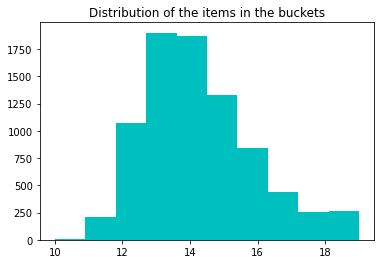

In [7]:
file = "hash.txt" 
card = hyperloglog(file)
print('Cardinality: ', card)

### Error of the hyperloglog:
In order to see the error of our hyperloglog we can compare the value of distinct elements in the file hash.txt and the obtained cardinality.

In [8]:
def error(cardinality):
    real_len = 125000001 # obtained with set(file)
    error = round(((real_len-card)/real_len)*100,2)
    return error

In [9]:
err = error(card)
print('Error: ',err,'%')

Error:  0.39 %


The standard error of the algorithm is given instead by the formula:  $1.04/\sqrt{m}$

In [10]:
m=2**13
std_error = round(1.04/np.sqrt(m),4)
print('Standard error: ',std_error,'%')

Standard error:  0.0115 %


As we can see our error is not significantly dissimilar to the SE and so we can conclude that the result we provide is pretty much accurate.